In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

seeed = 185

# cHANGELIST

* Loading and resizing images now done together in the same block
* Invalid image paths are removed
* More model architectures are considered.

In [2]:
import os

# Customised for Windows setup
# os.chdir('SharedFiles/MAST30034-Group-Project/')

In [3]:
# Customised for Mac/Linux setup
raw_data = pd.read_csv("kaggle_bee_vs_wasp/labels.csv")
raw_data['path'] = raw_data['path'].str.replace("\\", "/")

By removing the low quality photos, we get rid of the is_other instances

In [4]:
high_quality_entries = raw_data[raw_data["photo_quality"] == 1]
high_quality_entries =high_quality_entries[high_quality_entries["label"] != "insect"]

In [5]:
print(high_quality_entries.shape)
high_quality_entries.head()

(4596, 10)


,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1/10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1/10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1/10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1/1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1/10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee


In [6]:
[_,label_num] = np.unique(high_quality_entries["label"].values, return_inverse = True)
high_quality_entries.insert(loc = 0, column = "label_num", value = label_num)

In [7]:
print(high_quality_entries.shape)

for ind, row in high_quality_entries.iterrows():
    if not os.path.exists("kaggle_bee_vs_wasp/" + row['path']):
        #print(row)
        high_quality_entries = high_quality_entries.drop(ind)
        
print(high_quality_entries.shape)

(4596, 11)
(4592, 11)


In [8]:
# no non-insects found in the dataset
list(high_quality_entries["is_other"]).count(1)

0

In [9]:
3 in list(high_quality_entries["label_num"].values)

False

In [10]:
#taking a random sample for faster training time
# high_quality_entries = high_quality_entries.sample(1000)

In [11]:
images_path = high_quality_entries["path"].values.reshape(-1, 1)
labels = high_quality_entries["label"].values.reshape(-1, 1)

# Data

In [12]:
from matplotlib.image import imread
from skimage.transform import resize

In [13]:
images = []

# random_sample = high_quality_entries.sample(10)
# Train 50 for now just to get the code running

# Read, resize, store
for image_path in images_path:
    img = imread(os.path.join("kaggle_bee_vs_wasp", image_path[0]))
    img = resize(img, (224,224))
    images.append(img)

# Removed wrong size
images_to_remove_indecies = []

for im in range(len(images)):
    if images[im].shape != (224,224,3):
        #print(im)
        images_to_remove_indecies.append(im)

for index in images_to_remove_indecies:
    print(index)

#remove the labels of the anomalous images
labels_deleted = np.delete(labels, images_to_remove_indecies)

for im in reversed(images_to_remove_indecies):
    print(im)
    del images[im]
    
image_array = np.array(images)
print('Number of images:', image_array.shape)
print('Number of labels:', labels_deleted.shape)

1667
4030
4030
1667
Number of images: (4590, 224, 224, 3)
Number of labels: (4590,)


In [14]:
# #If you need to check the images.

# #imread outputs integers between 0-255

# images[0]
# f,ax = plt.subplots(3,3)
# for i in range(3):
#     for j in range(3):
#         ax[i,j].imshow(images[i+3*j])

## Encoding the image labels

In [15]:
from sklearn.preprocessing import LabelEncoder

In [16]:
# Encode as integers
encoder = LabelEncoder()
transformed_label = encoder.fit_transform(np.ravel(labels_deleted))

print('number of labels:', len(transformed_label))

number of labels: 4590


In [17]:
np.unique(transformed_label, return_counts=True)

(array([0, 1]), array([2468, 2122]))

In [18]:
# OR baseline
print(max(np.unique(transformed_label, return_counts=True)[1])/len(transformed_label)) 
# 54% is the baseline

0.5376906318082789


# Data augmentation

Split a training set from a validation set first, to prevent data leakage.
Augment a training set.

https://stats.stackexchange.com/questions/175504/how-to-do-data-augmentation-and-train-validate-split

In [19]:
#Train/validation/test split
from sklearn.model_selection import train_test_split

# 15% in test
Xtrain, Xtest, Ytrain, Ytest = train_test_split(image_array, transformed_label, 
                                              test_size = 0.15, random_state = seeed, 
                                              stratify = transformed_label)

# of 70%, 20% in validation
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, 
                                              test_size = 0.18, random_state = seeed, 
                                              stratify = Ytrain)

#70% training, 15% validation, 15% in test

print('Total:', image_array.shape, transformed_label.shape)
print('Train:', Xtrain.shape, Ytrain.shape)
print('Val:', Xval.shape, Yval.shape)
print('Test:', Xtest.shape, Ytest.shape)

Total: (4590, 224, 224, 3) (4590,)
Train: (3198, 224, 224, 3) (3198,)
Val: (703, 224, 224, 3) (703,)
Test: (689, 224, 224, 3) (689,)


In [20]:
# Augmented training data
train_generator = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True, 
    featurewise_std_normalization=True,
    rotation_range=90,
    zoom_range=0.4,
    horizontal_flip=True,
    # vertical_flip==True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    channel_shift_range=0.3)

# No augmentation on validation
val_generator = keras.preprocessing.image.ImageDataGenerator()

train_generator.fit(Xtrain)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


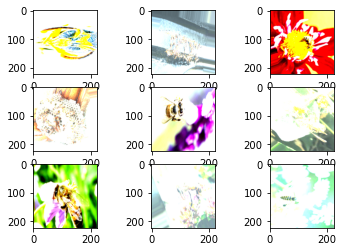

In [21]:
# If images need to be viewed, use batch size 1. Else keep batch size 32

augmented_train = train_generator.flow(Xtrain, Ytrain, batch_size=1)

for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = augmented_train.next()
    # convert to unsigned integers for viewing
    image = batch[0]
#     # plot raw pixel data
    image = np.reshape(image, (224,224,3))
    plt.imshow(image)

# Model Construction

## Metrics: Accuracy and Loss

In [22]:
def plot_model_metrics(hist):

    f, ax = plt.subplots(2,1)
    f.subplots_adjust(hspace=0.6)

    ax[0].plot(np.arange(0,len(hist.history['accuracy'])), hist.history['accuracy'])
    ax[0].plot(np.arange(0,len(hist.history['val_accuracy'])), hist.history['val_accuracy'])
    ax[0].legend(['training', 'validation'])

    ax[0].set_xticks(ticks=np.arange(0,len(hist.history['accuracy'])))
    
    ax[0].set_xticklabels(labels=np.arange(0,len(hist.history['accuracy'])))
    ax[0].set_xlim(0,len(hist.history['accuracy']))
    ax[0].set_xlabel('Epochs')
    ax[0].set_title('Model Accuracy')

    ax[1].plot(np.arange(0,len(hist.history['loss'])), hist.history['loss'])
    ax[1].plot(np.arange(0,len(hist.history['val_loss'])), hist.history['val_loss'])
    ax[1].legend(['training', 'validation'])

    ax[1].set_xticks(ticks=np.arange(0,len(hist.history['accuracy'])))
    ax[1].set_xticklabels(labels=np.arange(0,len(hist.history['accuracy'])))
    ax[1].set_xlim(0,len(hist.history['accuracy']))
    ax[1].set_xlabel('Epochs')
    ax[1].set_title('Loss')
    

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

def confusion_report(truth, predictions):
    '''
    Input:
        truth - true labels
        predictions - model.predict(data)
    '''
    print(classification_report(truth, np.argmax(predictions, axis=-1)))
    print(confusion_matrix(truth, np.argmax(predictions, axis=-1)))

# Model - MobileNetV2 (baseline)

3692 images in a training set. Augmented images will be generated from this set for training.

1231 unaugmented images will be used for validation.

In [107]:
mbnet = keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet')
avg = keras.layers.GlobalAveragePooling2D()(mbnet.output)
#drop = keras.layers.Dropout(0.7)(avg)
output = keras.layers.Dense(2, activation='sigmoid')(avg)

m0 = keras.Model(inputs = mbnet.input, outputs = output)

for layer in mbnet.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum= 0.9, decay = 0.01)

m0.compile(loss="sparse_categorical_crossentropy", 
           optimizer=optimizer,
           metrics=["accuracy"])

In [103]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.005, restore_best_weights=True)


h0 = m0.fit(train_generator.flow(Xtrain, Ytrain, batch_size=32), 
            epochs=23, steps_per_epoch=20,
            validation_data = (Xval, Yval),
            callbacks = [callback])

# Batches per epoch changed so that 1 epoch = 1 cycle of length len(Xtrain)

# Trains 3,200 images
# Validates on len(Yval) (should be entire validation set)

Epoch 1/23
20/20 [==============================] - 37s 2s/step - loss: 5.3812 - accuracy: 0.7547 - val_loss: 2.4750 - val_accuracy: 0.9189
Epoch 2/23
20/20 [==============================] - 42s 2s/step - loss: 5.3325 - accuracy: 0.8172 - val_loss: 1.8761 - val_accuracy: 0.9033
Epoch 3/23
20/20 [==============================] - 37s 2s/step - loss: 4.4237 - accuracy: 0.8150 - val_loss: 1.9493 - val_accuracy: 0.9118
Epoch 4/23
20/20 [==============================] - 32s 2s/step - loss: 3.2462 - accuracy: 0.8668 - val_loss: 2.0111 - val_accuracy: 0.9104
Epoch 5/23
20/20 [==============================] - 33s 2s/step - loss: 3.5534 - accuracy: 0.8469 - val_loss: 3.3288 - val_accuracy: 0.8350


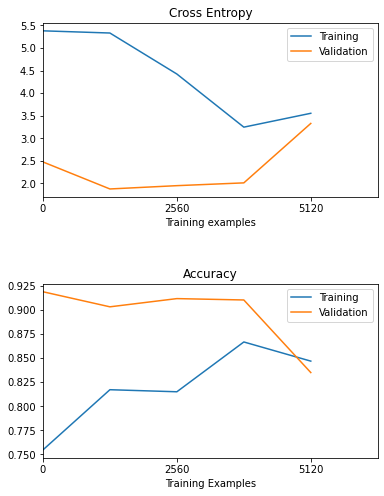

In [106]:
hist = h0

f, ax = plt.subplots(2,1)
f.subplots_adjust(hspace=0.5)
f.set_figwidth(6)
f.set_figheight(8)

ax[0].plot(np.arange(0,len(hist.history['loss'])), hist.history['loss'])
ax[0].plot(np.arange(0,len(hist.history['val_loss'])), hist.history['val_loss'])
ax[0].legend(['Training', 'Validation'])

ax[0].set_xticks(ticks=np.arange(0,len(hist.history['accuracy']),2))
ax[0].set_xticklabels(labels=1280*np.arange(0,len(hist.history['accuracy']),2))

ax[0].set_xlim(0,len(hist.history['accuracy']))
ax[0].set_xlabel('Training examples')
ax[0].set_title('Cross Entropy')
# ax[0].set_ylim(0.75,0.95)

ax[1].plot(np.arange(0,len(hist.history['accuracy'])), hist.history['accuracy'])
ax[1].plot(np.arange(0,len(hist.history['val_accuracy'])), hist.history['val_accuracy'])
ax[1].legend(['Training', 'Validation'])

ax[1].set_xticks(ticks=np.arange(0,len(hist.history['accuracy']),2))

ax[1].set_xticklabels(labels=1280*np.arange(0,len(hist.history['accuracy']),2))
ax[1].set_xlim(0,len(hist.history['accuracy']))
ax[1].set_xlabel('Training Examples')
ax[1].set_title('Accuracy')

f.savefig('BestLearningCurve.png', dpi=300)

In [83]:
m0.evaluate(Xtest,Ytest)

22/22 [==============================] - 16s 706ms/step - loss: 1.4725 - accuracy: 0.8868


[1.4725414514541626, 0.8867924809455872]

In [84]:
Xtrain.shape

(3198, 224, 224, 3)

In [85]:
Ytrain[4]

0

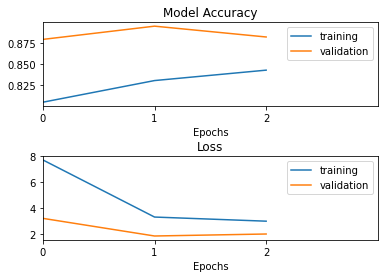

In [86]:
plot_model_metrics(h0)

In [87]:
confusion_report(Ytrain, m0.predict(Xtrain))

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      1720
           1       0.86      0.93      0.89      1478

    accuracy                           0.90      3198
   macro avg       0.90      0.90      0.90      3198
weighted avg       0.90      0.90      0.90      3198

[[1492  228]
 [ 101 1377]]


In [88]:
confusion_report(Yval, m0.predict(Xval))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88       378
           1       0.83      0.93      0.88       325

    accuracy                           0.88       703
   macro avg       0.88      0.89      0.88       703
weighted avg       0.89      0.88      0.88       703

[[318  60]
 [ 23 302]]


In [89]:
confusion_report(Ytest, m0.predict(Xtest))

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       370
           1       0.85      0.92      0.88       319

    accuracy                           0.89       689
   macro avg       0.89      0.89      0.89       689
weighted avg       0.89      0.89      0.89       689

[[316  54]
 [ 24 295]]


# Model Design

Speeding up training:
* Batch normalisation, Adam optimisation

Design options
* Convolution: Window size, Stride
* Activation functions: Softmax, ReLU
* Pooling: Average, Max
* Dense layer - fully connected.

Regularisation options
* Dropout: for regularisation

Other options
* Residual block (resnet)
* Batch normalisation: makes models faster and more stable.

Design recommendations
* Multiple 3x3 convolutions are preferred. (https://medium.com/analytics-vidhya/how-to-choose-the-size-of-the-convolution-filter-or-kernel-size-for-cnn-86a55a1e2d15, VGGNet?)
* Downsample by using pooling to reduce spatial information
* Common paradigm is to use max pooling in the network, and average pooling at the end, before the last dense layer
* Depth tends to result in higher accuracy

After all this, try to augment the data:
* rotations
* flips
* slight colour changes (for lighting conditions)

In [ ]:
       
# Filter: number of filters to learn - to be specified
# kernel_size: height and width of filter - to be specified
# Strides = (1,1) by default (no skip).
# Padding (if a filter doesn't fit)
# Activation = 'relu' (applied after calculations)
# Bias = True by default

# Consider regularisers after
# m1.add(keras.layers.BatchNormalization())
# m1.add(keras.layers.Dropout(0.5))
# m1.add(keras.layers.Activation("relu"))
# m1.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
# m1.add(keras.layers.GlobalAvgPool2D())
# m1.add(keras.layers.Flatten())
# m1.add(keras.layers.Dense(10, activation="softmax"))


## Original Model

In [93]:
m1 = keras.models.Sequential()

m1.add(keras.Input(shape = (224, 224, 3)))

m1.add(keras.layers.Conv2D(32, 3, activation = 'relu', padding='same'))
m1.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
# m1.add(keras.layers.BatchNormalization())

m1.add(keras.layers.Conv2D(16, 3, activation = 'relu', padding='same'))
m1.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
m1.add(keras.layers.BatchNormalization())


m1.add(keras.layers.Flatten())
m1.add(keras.layers.Dense(16, activation="relu"))
m1.add(keras.layers.BatchNormalization())

# m1.add(keras.layers.Dense(128, activation="relu"))
# # m1.add(keras.layers.GlobalAveragePooling2D())
# m1.add(keras.layers.BatchNormalization())
m1.add(keras.layers.Dense(2, activation="sigmoid"))

optimizer = keras.optimizers.SGD(lr=0.05, momentum= 0.9, decay = 0.01)

m1.compile(loss="sparse_categorical_crossentropy",
           optimizer="adam",
           metrics=["accuracy"])

In [94]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.005, restore_best_weights=True)

h1 = m1.fit(train_generator.flow(Xtrain, Ytrain, batch_size=32), 
            epochs=15, steps_per_epoch=20,
            validation_data = (Xval, Yval),
            callbacks=[callback])

# 32*20 = 640 examples per epoch
# 15,000/640 = 23 epochs to cycle over the original size * 3

Epoch 1/15
20/20 [==============================] - 21s 1s/step - loss: 0.7386 - accuracy: 0.5484 - val_loss: 0.6738 - val_accuracy: 0.5533
Epoch 2/15
20/20 [==============================] - 17s 861ms/step - loss: 0.6272 - accuracy: 0.6484 - val_loss: 0.6678 - val_accuracy: 0.5377
Epoch 3/15
20/20 [==============================] - 17s 854ms/step - loss: 0.6211 - accuracy: 0.6469 - val_loss: 0.6598 - val_accuracy: 0.5775
Epoch 4/15
20/20 [==============================] - 19s 932ms/step - loss: 0.5922 - accuracy: 0.6583 - val_loss: 0.6608 - val_accuracy: 0.5491
Epoch 5/15
20/20 [==============================] - 17s 865ms/step - loss: 0.6169 - accuracy: 0.6750 - val_loss: 0.6441 - val_accuracy: 0.5818
Epoch 6/15
20/20 [==============================] - 18s 875ms/step - loss: 0.5589 - accuracy: 0.7172 - val_loss: 0.6300 - val_accuracy: 0.6799
Epoch 7/15
20/20 [==============================] - 16s 808ms/step - loss: 0.5315 - accuracy: 0.7453 - val_loss: 0.6502 - val_accuracy: 0.5804
Ep

In [63]:
Xtrain.shape

(3198, 224, 224, 3)

In [64]:
Xtrain.shape

(3198, 224, 224, 3)

In [65]:
h1.model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 112, 112, 8)       2312      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 56, 56, 8)         32        
_________________________________________________________________
flatten_8 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)               

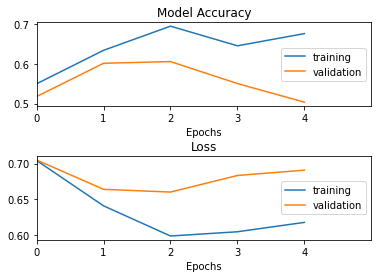

In [29]:
plot_model_metrics(h1)

In [30]:
m1.evaluate(Xtest, Ytest)

22/22 [==============================] - 6s 278ms/step - loss: 1.3917 - accuracy: 0.4644


[1.3917021751403809, 0.4644412100315094]

In [97]:
confusion_report(Ytrain, m1.predict(Xtrain))

              precision    recall  f1-score   support

           0       0.68      0.87      0.76      1720
           1       0.77      0.52      0.62      1478

    accuracy                           0.71      3198
   macro avg       0.73      0.69      0.69      3198
weighted avg       0.72      0.71      0.70      3198

[[1494  226]
 [ 710  768]]


In [98]:
confusion_report(Yval, m1.predict(Xval))

              precision    recall  f1-score   support

           0       0.69      0.89      0.78       378
           1       0.81      0.53      0.64       325

    accuracy                           0.73       703
   macro avg       0.75      0.71      0.71       703
weighted avg       0.75      0.73      0.72       703

[[338  40]
 [152 173]]


In [99]:
confusion_report(Ytest, m1.predict(Xtest))

              precision    recall  f1-score   support

           0       0.66      0.84      0.74       370
           1       0.73      0.50      0.59       319

    accuracy                           0.68       689
   macro avg       0.69      0.67      0.67       689
weighted avg       0.69      0.68      0.67       689

[[311  59]
 [160 159]]


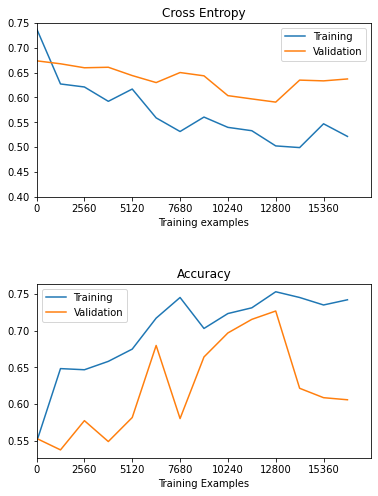

In [100]:
hist = h1

f, ax = plt.subplots(2,1)
f.subplots_adjust(hspace=0.5)
f.set_figwidth(6)
f.set_figheight(8)

ax[0].plot(np.arange(0,len(hist.history['loss'])), hist.history['loss'])
ax[0].plot(np.arange(0,len(hist.history['val_loss'])), hist.history['val_loss'])
ax[0].legend(['Training', 'Validation'])

ax[0].set_xticks(ticks=np.arange(0,len(hist.history['accuracy']),2))
ax[0].set_xticklabels(labels=1280*np.arange(0,len(hist.history['accuracy']),2))

ax[0].set_xlim(0,len(hist.history['accuracy']))
ax[0].set_xlabel('Training examples')
ax[0].set_title('Cross Entropy')
ax[0].set_ylim(0.40,0.75)

ax[1].plot(np.arange(0,len(hist.history['accuracy'])), hist.history['accuracy'])
ax[1].plot(np.arange(0,len(hist.history['val_accuracy'])), hist.history['val_accuracy'])
ax[1].legend(['Training', 'Validation'])

ax[1].set_xticks(ticks=np.arange(0,len(hist.history['accuracy']),2))

ax[1].set_xticklabels(labels=1280*np.arange(0,len(hist.history['accuracy']),2))
ax[1].set_xlim(0,len(hist.history['accuracy']))
ax[1].set_xlabel('Training Examples')
ax[1].set_title('Accuracy')

f.savefig('BestLearningCurve.png', dpi=300)

# M2

In [110]:
m2 = keras.models.Sequential()

#narrow stride and pool side to capture finer details

m2.add(keras.layers.Conv2D(64, 3, activation = 'relu', padding='same'))
m2.add(keras.layers.BatchNormalization())
m2.add(keras.layers.MaxPool2D(pool_size=2, strides=1, padding="same"))

m2.add(keras.layers.Conv2D(64, 3, activation = 'relu', padding='same'))
m2.add(keras.layers.BatchNormalization())
m2.add(keras.layers.MaxPool2D(pool_size=2, strides=1, padding="same"))

m2.add(keras.layers.Flatten())
# m2.add(keras.layers.Dropout(0.3))
m2.add(keras.layers.Dense(16, activation="relu"))
m2.add(keras.layers.BatchNormalization())
m2.add(keras.layers.Dense(2, activation="softmax"))

# optimizer = keras.optimizers.SGD(lr=0.2, momentum= 0.9, decay = 0.01)
#optimizer = keras.optimizers.Adam()

m2.compile(loss="sparse_categorical_crossentropy",
           optimizer="adam",
           metrics=['accuracy'])


In [111]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.01)

h2 = m2.fit(train_generator.flow(Xtrain, Ytrain, batch_size=32), 
            epochs=23, steps_per_epoch=20,
            validation_data = (Xval, Yval),
            callbacks=[callback])

# 32*20 = 640 examples per epoch
# 15,000/640 = 23 epochs to cycle over the original size * 3

Epoch 1/23
20/20 [==============================] - 141s 7s/step - loss: 1.0494 - accuracy: 0.5219 - val_loss: 0.6926 - val_accuracy: 0.5064
Epoch 2/23
20/20 [==============================] - 126s 6s/step - loss: 0.7346 - accuracy: 0.5984 - val_loss: 0.7112 - val_accuracy: 0.4765
Epoch 3/23
20/20 [==============================] - 118s 6s/step - loss: 0.6561 - accuracy: 0.6219 - val_loss: 0.7342 - val_accuracy: 0.4552
Epoch 4/23
20/20 [==============================] - 114s 6s/step - loss: 0.6626 - accuracy: 0.6317 - val_loss: 0.7455 - val_accuracy: 0.4623


In [112]:
h2.model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, None, None, 64)    1792      
_________________________________________________________________
batch_normalization_33 (Batc (None, None, None, 64)    256       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, None, None, 64)    0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, None, None, 64)    36928     
_________________________________________________________________
batch_normalization_34 (Batc (None, None, None, 64)    256       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, None, None, 64)    0         
_________________________________________________________________
flatten_15 (Flatten)         (None, None)            

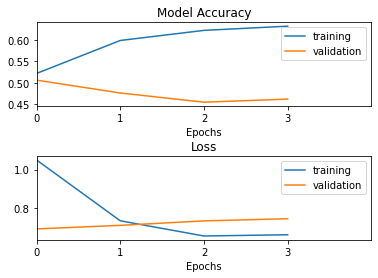

In [113]:
plot_model_metrics(h2)

In [114]:
m1.evaluate(Xtest, Ytest)

22/22 [==============================] - 3s 154ms/step - loss: 0.5982 - accuracy: 0.6821


[0.5982046127319336, 0.6821480393409729]

In [115]:
confusion_report(Ytrain, m1.predict(Xtrain))

              precision    recall  f1-score   support

           0       0.68      0.87      0.76      1720
           1       0.77      0.52      0.62      1478

    accuracy                           0.71      3198
   macro avg       0.73      0.69      0.69      3198
weighted avg       0.72      0.71      0.70      3198

[[1494  226]
 [ 710  768]]


In [116]:
confusion_report(Yval, m1.predict(Xval))

              precision    recall  f1-score   support

           0       0.69      0.89      0.78       378
           1       0.81      0.53      0.64       325

    accuracy                           0.73       703
   macro avg       0.75      0.71      0.71       703
weighted avg       0.75      0.73      0.72       703

[[338  40]
 [152 173]]


In [117]:
confusion_report(Ytest, m2.predict(Xtest))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       370
           1       0.46      1.00      0.63       319

    accuracy                           0.46       689
   macro avg       0.23      0.50      0.32       689
weighted avg       0.21      0.46      0.29       689

[[  0 370]
 [  0 319]]


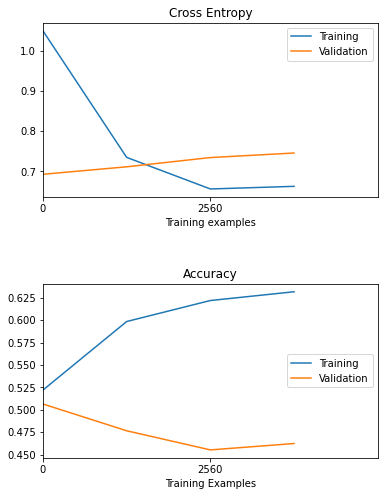

In [118]:
hist = h2

f, ax = plt.subplots(2,1)
f.subplots_adjust(hspace=0.5)
f.set_figwidth(6)
f.set_figheight(8)

ax[0].plot(np.arange(0,len(hist.history['loss'])), hist.history['loss'])
ax[0].plot(np.arange(0,len(hist.history['val_loss'])), hist.history['val_loss'])
ax[0].legend(['Training', 'Validation'])

ax[0].set_xticks(ticks=np.arange(0,len(hist.history['accuracy']),2))
ax[0].set_xticklabels(labels=1280*np.arange(0,len(hist.history['accuracy']),2))

ax[0].set_xlim(0,len(hist.history['accuracy']))
ax[0].set_xlabel('Training examples')
ax[0].set_title('Cross Entropy')
# ax[0].set_ylim(0.75,0.95)

ax[1].plot(np.arange(0,len(hist.history['accuracy'])), hist.history['accuracy'])
ax[1].plot(np.arange(0,len(hist.history['val_accuracy'])), hist.history['val_accuracy'])
ax[1].legend(['Training', 'Validation'])

ax[1].set_xticks(ticks=np.arange(0,len(hist.history['accuracy']),2))

ax[1].set_xticklabels(labels=1280*np.arange(0,len(hist.history['accuracy']),2))
ax[1].set_xlim(0,len(hist.history['accuracy']))
ax[1].set_xlabel('Training Examples')
ax[1].set_title('Accuracy')

f.savefig('BestLearningCurve.png', dpi=300)

# Results 1

In [88]:
# m2 = keras.models.Sequential()

# m2.add(keras.layers.Conv2D(32, 3, activation = 'relu', padding='same'))
# m2.add(keras.layers.BatchNormalization())
# m2.add(keras.layers.Conv2D(32, 3, activation = 'relu', padding='same'))
# m2.add(keras.layers.BatchNormalization())
# m2.add(keras.layers.MaxPool2D(pool_size=3, strides=1, padding="same"))

# m2.add(keras.layers.Conv2D(16, 3, activation = 'relu', padding='same'))
# m2.add(keras.layers.BatchNormalization())
# m2.add(keras.layers.Conv2D(16, 3, activation = 'relu', padding='same'))
# m2.add(keras.layers.BatchNormalization())
# m2.add(keras.layers.MaxPool2D(pool_size=3, strides=1, padding="same"))

# m2.add(keras.layers.Flatten())
# m2.add(keras.layers.Dropout(0.7))
# m2.add(keras.layers.Dense(16, activation="relu"))
# m2.add(keras.layers.BatchNormalization())
# m2.add(keras.layers.Dense(3, activation="softmax"))

# optimizer = keras.optimizers.SGD(lr=0.2, momentum= 0.9, decay = 0.01)
# #optimizer = keras.optimizers.Adam()

# m2.compile(loss="sparse_categorical_crossentropy",
#            optimizer=optimizer,
#            metrics=['accuracy'])


In [89]:
# callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.05)

# h2 = m2.fit(train_generator.flow(Xtrain, Ytrain, batch_size=32), 
#             epochs=23, steps_per_epoch=20,
#             validation_data = (Xval, Yval),
#             callbacks=[callback])

# # 32*20 = 640 examples per epoch
# # 15,000/640 = 23 epochs to cycle over the original size * 3

In [90]:
# plot_model_metrics(h2)

# Result 2

In [91]:
# m2 = keras.models.Sequential()

# m2.add(keras.layers.Conv2D(256, 3, activation = 'relu', padding='same'))
# m2.add(keras.layers.BatchNormalization())
# m2.add(keras.layers.MaxPool2D(pool_size=2, strides=1, padding="same"))

# m2.add(keras.layers.Conv2D(256, 3, activation = 'relu', padding='same'))
# m2.add(keras.layers.BatchNormalization())
# m2.add(keras.layers.MaxPool2D(pool_size=2, strides=1, padding="same"))

# m2.add(keras.layers.Flatten())
# m2.add(keras.layers.Dropout(0.7))
# m2.add(keras.layers.Dense(16, activation="relu"))
# m2.add(keras.layers.BatchNormalization())
# m2.add(keras.layers.Dense(3, activation="softmax"))

# optimizer = keras.optimizers.SGD(lr=0.2, momentum= 0.9, decay = 0.01)
# #optimizer = keras.optimizers.Adam()

# m2.compile(loss="sparse_categorical_crossentropy",
#            optimizer=optimizer,
#            metrics=['accuracy'])


In [92]:
# callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.05)

# h2 = m2.fit(train_generator.flow(Xtrain, Ytrain, batch_size=32), 
#             epochs=23, steps_per_epoch=20,
#             validation_data = (Xval, Yval),
#             callbacks=[callback])

# # 32*20 = 640 examples per epoch
# # 15,000/640 = 23 epochs to cycle over the original size * 3

In [93]:
# plot_model_metrics(h2)

# results3

In [94]:
# plot_model_metrics(h2

In [95]:
# m2 = keras.models.Sequential()

# #narrow stride and pool side to capture finer details

# m2.add(keras.layers.Conv2D(128, 3, activation = 'relu', padding='same'))
# m2.add(keras.layers.BatchNormalization())
# m2.add(keras.layers.MaxPool2D(pool_size=2, strides=1, padding="same"))

# m2.add(keras.layers.Conv2D(64, 3, activation = 'relu', padding='same'))
# m2.add(keras.layers.BatchNormalization())
# m2.add(keras.layers.MaxPool2D(pool_size=2, strides=1, padding="same"))

# m2.add(keras.layers.Conv2D(32, 3, activation = 'relu', padding='same'))
# m2.add(keras.layers.BatchNormalization())
# m2.add(keras.layers.MaxPool2D(pool_size=2, strides=1, padding="same"))

# m2.add(keras.layers.Flatten())
# m2.add(keras.layers.Dropout(0.7))
# m2.add(keras.layers.Dense(16, activation="relu"))
# m2.add(keras.layers.BatchNormalization())
# m2.add(keras.layers.Dense(3, activation="softmax"))

# optimizer = keras.optimizers.SGD(lr=0.2, momentum= 0.9, decay = 0.01)
# #optimizer = keras.optimizers.Adam()

# m2.compile(loss="sparse_categorical_crossentropy",
#            optimizer=optimizer,
#            metrics=['accuracy'])


In [96]:
# callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.05)

# h2 = m2.fit(train_generator.flow(Xtrain, Ytrain, batch_size=32), 
#             epochs=23, steps_per_epoch=20,
#             validation_data = (Xval, Yval),
#             callbacks=[callback])

# # 32*20 = 640 examples per epoch
# # 15,000/640 = 23 epochs to cycle over the original size * 3